# Test Synthesis Method Prompting for Scientific Papers

## Executive Summary

**Objective**: Improve AI extraction of synthesis methods from scientific papers by transitioning from constraint-based to example-guided prompting approaches.

1. **Improved Accuracy**: Better extraction of author-specific terminology
2. **Novel Method Detection**: Captures synthesis methods not in standard lists
3. **Model Flexibility**: Choose optimal models for material and synthesis extraction
4. **Scientific Precision**: Preserves exact technical language from papers
5. **Structured Output**: Maintains JSON compatibility for downstream processing

You can test a flexible configuration: Supports any LLM model based on what we have access

## 1. Environment Setup

In [6]:
# Required imports
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any
import warnings

# LLM synthesis modules
from llm_synthesis.utils.dspy_utils import configure_dspy
from llm_synthesis.transformers.synthesis_extraction.dspy_synthesis_extraction import (
    DspySynthesisExtractor, 
    make_dspy_synthesis_extractor_signature
)

warnings.filterwarnings('ignore')
print("✅ Environment setup complete")

✅ Environment setup complete


In [7]:
# Standard synthesis methods ontology
SYNTHESIS_METHODS = [
    "PVD", "CVD", "arc discharge", "ball milling", "spray pyrolysis",
    "electrospinning", "sol-gel", "hydrothermal", "solvothermal", 
    "precipitation", "coprecipitation", "combustion", "microwave-assisted",
    "sonochemical", "template-directed", "solid-state", "flux growth",
    "float zone & Bridgman", "arc melting & induction melting", 
    "spark plasma sintering", "electrochemical deposition", 
    "chemical bath deposition", "liquid-phase epitaxy", "self-assembly",
    "atomic layer deposition", "molecular beam epitaxy", 
    "pulsed laser deposition", "ion implantation", "lithographic patterning",
    "wet impregnation", "incipient wetness impregnation", "mechanical mixing", "other"
]

print(f"📝 Standard synthesis methods: {len(SYNTHESIS_METHODS)} entries loaded")

📝 Standard synthesis methods: 33 entries loaded


## 2. Flexible Model Configuration

Configure your preferred models for different extraction tasks. You can use any supported LLM model based on your requirements and access.

In [8]:
# Flexible model configuration
def configure_extraction_model(model_name, task_type="synthesis_extraction"):
    """
    Configure model for extraction tasks
    
    Args:
        model_name: Model identifier (e.g., "gemini-2.0-flash")
        task_type: "synthesis_extraction" or "material_extraction"
    """
    if task_type == "synthesis_extraction":
        model_kwargs = {"temperature": 0.1, "max_tokens": 4000, "max_retries": 3}
    elif task_type == "material_extraction":
        model_kwargs = {"temperature": 0.1, "max_tokens": 2000, "max_retries": 3}
    else:
        model_kwargs = {"temperature": 0.2, "max_tokens": 4000, "max_retries": 3}
    
    configure_dspy(lm=model_name, model_kwargs=model_kwargs)
    return model_name

# Model preferences - customize as needed
PREFERRED_MODELS = {
    "synthesis_extraction": "gemini-2.0-flash",
    "material_extraction": "gemini-2.0-flash",
}

print("✅ Model configuration ready")
print(f"🎯 Synthesis extraction: {PREFERRED_MODELS['synthesis_extraction']}")
print(f"🎯 Material extraction: {PREFERRED_MODELS['material_extraction']}")

# Initialize primary model
current_model = configure_extraction_model(
    PREFERRED_MODELS["synthesis_extraction"], 
    "synthesis_extraction"
)
print(f"🚀 Model initialized: {current_model}")

✅ Model configuration ready
🎯 Synthesis extraction: gemini-2.0-flash
🎯 Material extraction: gemini-2.0-flash
Configured dspy with 'gemini-2.0-flash' and model_kwargs={'temperature': 0.1, 'max_tokens': 4000, 'max_retries': 3}
🚀 Model initialized: gemini-2.0-flash


## 3. Test Dataset

In [9]:
# Curated test dataset with diverse synthesis methods
TEST_PAPERS = [
    {
        "id": "paper_1",
        "title": "Hydrothermal Synthesis of ZnO Nanorods",
        "text": """
        For the synthesis of ZnO nanorods, a sealed Teflon-lined stainless steel autoclave 
        was filled with an aqueous solution of zinc nitrate and hexamethylenetetramine. 
        The autoclave was then maintained at 90°C for 12 hours before being cooled to 
        room temperature. The resulting white product was collected and washed.
        """,
        "expected_method": "hydrothermal"
    },
    {
        "id": "paper_2", 
        "title": "SILAR Deposition of CdS Thin Films",
        "text": """
        The CdS thin films were prepared on glass substrates from an aqueous solution 
        containing cadmium chloride and thiourea. The deposition process involved the 
        alternate immersion of the substrate into separate cationic and anionic precursor 
        solutions, a technique we refer to as Sequential Ion-Layer Adsorption and 
        Reaction (SILAR). Each immersion was followed by rinsing with deionized water.
        """,
        "expected_method": "Sequential Ion-Layer Adsorption and Reaction (SILAR)"
    },
    {
        "id": "paper_3",
        "title": "Sol-Gel Synthesis of TiO2 Nanoparticles", 
        "text": """
        TiO2 nanoparticles were synthesized using a sol-gel method. Titanium isopropoxide 
        was mixed with ethanol and acetic acid under vigorous stirring. The resulting 
        gel was aged for 24 hours, then calcined at 500°C for 2 hours to obtain 
        crystalline TiO2 nanoparticles.
        """,
        "expected_method": "sol-gel"
    },
    {
        "id": "paper_4",
        "title": "Plasma-Enhanced CVD of Silicon Carbide",
        "text": """
        Silicon carbide films were deposited using plasma-enhanced chemical vapor 
        deposition (PECVD). Silane and methane gases were introduced into the chamber 
        at 350°C under RF plasma conditions. The substrate was maintained at 
        13.56 MHz frequency during the deposition process.
        """,
        "expected_method": "plasma-enhanced chemical vapor deposition (PECVD)"
    },
    {
        "id": "paper_5",
        "title": "Microfluidic Synthesis of Gold Nanoparticles",
        "text": """
        Gold nanoparticles were synthesized using a microfluidic droplet-based approach. 
        Aqueous solutions of HAuCl4 and sodium citrate were pumped through separate 
        microchannels and mixed in T-junction microreactors. The rapid mixing and 
        controlled residence time in the microfluidic device allowed for precise 
        control of particle size and monodispersity.
        """,
        "expected_method": "microfluidic droplet-based synthesis"
    },
    {
        "id": "paper_6",
        "title": "Laser Ablation Synthesis of Metal Nanoparticles",
        "text": """
        Silver nanoparticles were prepared by pulsed laser ablation in liquid (PLAL). 
        A silver target was submerged in deionized water and irradiated with a 
        Nd:YAG laser (1064 nm, 10 ns pulse duration) at 10 Hz repetition rate. 
        The laser-generated plasma plume resulted in the formation of colloidal 
        silver nanoparticles without chemical reducing agents.
        """,
        "expected_method": "pulsed laser ablation in liquid (PLAL)"
    },
    {
        "id": "paper_7",
        "title": "Freeze-Drying Synthesis of Porous Materials",
        "text": """
        Porous carbon materials were synthesized using a freeze-drying technique 
        followed by carbonization. The aqueous precursor solution containing glucose 
        and surfactant was rapidly frozen in liquid nitrogen, then lyophilized 
        for 48 hours to remove ice crystals. The resulting structure was carbonized 
        at 800°C under nitrogen atmosphere.
        """,
        "expected_method": "freeze-drying"
    },
    {
        "id": "paper_8",
        "title": "Biogenic Synthesis of Iron Oxide Nanoparticles",
        "text": """
        Iron oxide nanoparticles were biosynthesized using Bacillus subtilis bacteria. 
        The bacterial culture was grown in iron-rich medium for 72 hours, during which 
        the microorganisms reduced Fe3+ ions to form magnetite nanoparticles 
        intracellularly. This green synthesis approach eliminates the need for 
        toxic chemicals and high-temperature processing.
        """,
        "expected_method": "biogenic synthesis"
    },
    {
        "id": "paper_9",
        "title": "Vapor-Liquid-Solid Growth of Nanowires",
        "text": """
        Silicon nanowires were grown using the vapor-liquid-solid (VLS) mechanism. 
        Gold nanoparticles served as catalysts on silicon substrates. Silane gas 
        was decomposed at 450°C, forming a liquid Au-Si alloy droplet that became 
        supersaturated and precipitated silicon, resulting in one-dimensional 
        nanowire growth.
        """,
        "expected_method": "vapor-liquid-solid (VLS)"
    },
    {
        "id": "paper_10",
        "title": "Continuous Flow Synthesis in Tubular Reactors",
        "text": """
        CeO2 nanoparticles were synthesized using a continuous flow tubular reactor 
        system. Cerium nitrate and ammonia solutions were continuously fed into 
        a serpentine microchannel reactor maintained at 80°C. The continuous flow 
        setup enabled precise control of reaction time and temperature gradients, 
        resulting in uniform nanoparticle size distribution.
        """,
        "expected_method": "continuous flow synthesis"
    },
    {
        "id": "paper_11",
        "title": "One-Step Mechanochemical Synthesis of Polymer Composites",
        "text": """
        Polymer composite films were prepared using a one-step solvent-free mechanochemical 
        approach. The polymer matrix and nanofillers were first mixed in a high-energy 
        ball mill for 2 hours to achieve homogeneous dispersion. The resulting powder 
        mixture was then processed using polymer solution casting, where the mechanochemically 
        processed blend was dissolved in chloroform and cast onto glass substrates. 
        The solvent was allowed to evaporate at room temperature over 24 hours, 
        yielding uniform composite films with excellent mechanical properties.
        """,
        "expected_method": "polymer solution casting"
    }
]

# Dataset statistics
standard_methods = [p for p in TEST_PAPERS if any(method.lower() in p['expected_method'].lower() for method in SYNTHESIS_METHODS)]
novel_methods = [p for p in TEST_PAPERS if not any(method.lower() in p['expected_method'].lower() for method in SYNTHESIS_METHODS)]

print(f"📊 Test dataset: {len(TEST_PAPERS)} papers")
print(f"✅ Standard methods: {len(standard_methods)} papers")
print(f"🆕 Novel methods: {len(novel_methods)} papers")

📊 Test dataset: 11 papers
✅ Standard methods: 3 papers
🆕 Novel methods: 8 papers


## 4. Prompt Engineering Approaches

In [10]:
# Traditional constraint-based prompt
CONSTRAINT_PROMPT = f"""
You are a synthesis method extraction assistant. Extract the synthesis method for the specified material.

Choose synthesis method from this list: {SYNTHESIS_METHODS}

Output format:
{{
  "structured_synthesis": {{
    "target_compound": "string (required)",
    "synthesis_method": "string (required) - MUST be exactly one from the provided list",
    "target_compound_type": "string (required)"
  }}
}}
"""

# Enhanced example-based prompt
ENHANCED_PROMPT = """
You are a synthesis method extraction assistant. Extract the synthesis method for the specified material.

Identify the synthesis method using the exact terminology from the paper. Common techniques include 
sol-gel, CVD, hydrothermal, ball milling, electrospinning, but prioritize the specific terms used by the authors.

Output format:
{
  "structured_synthesis": {
    "target_compound": "string (required)",
    "synthesis_method": "string (required) - exact terminology from paper",
    "target_compound_type": "string (required)"
  }
}
"""

# Hybrid approach - guidance with flexibility
HYBRID_PROMPT = f"""
You are a synthesis method extraction assistant. Extract the synthesis method for the specified material.

EXTRACTION PROTOCOL:
1. Use EXACT terminology from the paper
2. Preserve complete method names and technical details
3. Include acronym definitions when provided
4. Reference methods for guidance: {SYNTHESIS_METHODS}
5. Prioritize author terminology over standardized terms

Output format:
{{
  "structured_synthesis": {{
    "target_compound": "string (required)",
    "synthesis_method": "string (required) - exact paper terminology",
    "target_compound_type": "string (required)"
  }}
}}
"""

PROMPT_APPROACHES = [
    ("Constraint-Based", CONSTRAINT_PROMPT),
    ("Enhanced", ENHANCED_PROMPT),
    ("Hybrid", HYBRID_PROMPT)
]

print(f"✅ Prompt approaches configured: {len(PROMPT_APPROACHES)}")

✅ Prompt approaches configured: 3


## 5. Extraction Functions

In [11]:
import dspy
import re

def extract_synthesis_method(paper_text: str, material_name: str, system_prompt: str, approach_name: str):
    """Extract synthesis method using specified prompt approach"""
    try:
        class SynthesisExtractor(dspy.Module):
            def __init__(self, system_prompt):
                super().__init__()
                self.system_prompt = system_prompt
                
            def forward(self, paper_text, material_name):
                full_prompt = f"{self.system_prompt}\n\nPaper text: {paper_text}\n\nMaterial: {material_name}"
                lm = dspy.settings.lm
                return lm(full_prompt)
                
        extractor = SynthesisExtractor(system_prompt)
        result = extractor.forward(paper_text, material_name)
        
        # Handle response formatting
        if isinstance(result, list):
            response_text = result[0] if len(result) == 1 else ' '.join(str(x) for x in result)
        else:
            response_text = str(result)
        
        # Parse JSON response
        json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
        if json_match:
            try:
                parsed = json.loads(json_match.group())
                if 'structured_synthesis' in parsed:
                    return {
                        'success': True,
                        'synthesis_method': parsed['structured_synthesis'].get('synthesis_method', 'Not found'),
                        'approach': approach_name,
                        'raw_response': response_text[:200] + '...' if len(response_text) > 200 else response_text
                    }
            except json.JSONDecodeError:
                pass
                
        return {
            'success': False,
            'synthesis_method': 'Extraction failed',
            'approach': approach_name,
            'raw_response': response_text[:200] + '...' if len(response_text) > 200 else response_text
        }
        
    except Exception as e:
        return {
            'success': False,
            'synthesis_method': f'Error: {str(e)}',
            'approach': approach_name,
            'raw_response': ''
        }

def evaluate_accuracy(expected: str, extracted: str) -> str:
    """Evaluate extraction accuracy"""
    if not extracted or 'Error' in extracted or 'failed' in extracted:
        return 'Failed'
    
    expected_lower = expected.lower()
    extracted_lower = extracted.lower()
    
    if expected_lower == extracted_lower:
        return 'Exact'
    elif expected_lower in extracted_lower or extracted_lower in expected_lower:
        return 'Partial'
    else:
        return 'Different'

def analyze_model_performance(results):
    """Analyze performance metrics for each model/approach"""
    analysis = {}
    
    for model_name, model_results in results.items():
        total = len(model_results)
        successful = sum(1 for r in model_results if r['success'])
        exact = sum(1 for r in model_results if r['accuracy'] == 'Exact')
        partial = sum(1 for r in model_results if r['accuracy'] == 'Partial')
        
        analysis[model_name] = {
            'total_papers': total,
            'success_rate': (successful / total) * 100,
            'exact_matches': exact,
            'partial_matches': partial,
            'accuracy_rate': ((exact + partial) / total) * 100
        }
    
    return analysis

print("✅ Extraction functions configured")

✅ Extraction functions configured


## 6. Synthesis Method Extraction Demonstration

Demonstrate the extraction system using your configured model and test dataset.

In [12]:
# Configure your preferred model for synthesis extraction
current_model = configure_extraction_model(
    PREFERRED_MODELS["synthesis_extraction"], 
    "synthesis_extraction"
)

print(f"🚀 Model configured for synthesis extraction: {current_model}")

# Demonstrate extraction with a sample paper
sample_paper = TEST_PAPERS[0]  # Use first paper as example
print(f"\n📄 Testing with: {sample_paper['title']}")
print(f"📝 Expected method: {sample_paper['expected_method']}")

# Extract material name from title
material_name = sample_paper['title'].split(' of ')[-1] if ' of ' in sample_paper['title'] else "target material"

# Test extraction with Enhanced prompt
result = extract_synthesis_method(
    sample_paper['text'], 
    material_name, 
    ENHANCED_PROMPT,
    "Enhanced"
)

accuracy = evaluate_accuracy(sample_paper['expected_method'], result['synthesis_method'])

print(f"\n🔍 Extraction Results:")
print(f"  ✅ Success: {result['success']}")
print(f"  📊 Extracted method: {result['synthesis_method']}")
print(f"  🎯 Accuracy: {accuracy}")

print(f"\n✅ Extraction system ready for use with {current_model}")
print("💡 You can now run the full prompt comparison analysis below")

Configured dspy with 'gemini-2.0-flash' and model_kwargs={'temperature': 0.1, 'max_tokens': 4000, 'max_retries': 3}
🚀 Model configured for synthesis extraction: gemini-2.0-flash

📄 Testing with: Hydrothermal Synthesis of ZnO Nanorods
📝 Expected method: hydrothermal

🔍 Extraction Results:
  ✅ Success: True
  📊 Extracted method: hydrothermal synthesis
  🎯 Accuracy: Partial

✅ Extraction system ready for use with gemini-2.0-flash
💡 You can now run the full prompt comparison analysis below


## 7. Prompt Approach Comparison

Compare different prompting strategies to find the optimal approach for your use case.

In [13]:
# Run prompt approach comparison
print(f"🧪 Using {PREFERRED_MODELS['synthesis_extraction']} for prompt approach comparison")

prompt_results = {}
print("🔄 Running prompt approach comparison...")

for approach_name, prompt in PROMPT_APPROACHES:
    print(f"\n🧪 Testing {approach_name} approach...")
    
    prompt_results[approach_name] = []
    
    for paper in TEST_PAPERS:
        material_name = paper['title'].split(' of ')[-1] if ' of ' in paper['title'] else "target material"
        
        result = extract_synthesis_method(
            paper['text'], 
            material_name, 
            prompt,
            approach_name
        )
        
        accuracy = evaluate_accuracy(paper['expected_method'], result['synthesis_method'])
        
        prompt_results[approach_name].append({
            'paper_id': paper['id'],
            'paper_title': paper['title'],
            'expected': paper['expected_method'],
            'extracted': result['synthesis_method'],
            'accuracy': accuracy,
            'success': result['success']
        })

print("\n✅ Prompt comparison complete")

🧪 Using gemini-2.0-flash for prompt approach comparison
🔄 Running prompt approach comparison...

🧪 Testing Constraint-Based approach...

🧪 Testing Enhanced approach...

🧪 Testing Hybrid approach...

✅ Prompt comparison complete


In [14]:
# Analyze prompt performance
prompt_analysis = analyze_model_performance(prompt_results)

print("📊 Prompt Approach Performance Analysis")
print("=" * 45)

for approach, metrics in prompt_analysis.items():
    print(f"\n💡 {approach} Approach:")
    print(f"  ✅ Success Rate: {metrics['success_rate']:.1f}%")
    print(f"  🎯 Exact Matches: {metrics['exact_matches']}/{metrics['total_papers']}")
    print(f"  🔄 Partial Matches: {metrics['partial_matches']}/{metrics['total_papers']}")
    print(f"  📈 Overall Accuracy: {metrics['accuracy_rate']:.1f}%")

# Determine best approach
best_approach = max(prompt_analysis.keys(), key=lambda x: prompt_analysis[x]['accuracy_rate'])
print(f"\n🏆 Best performing approach: {best_approach}")
print(f"📊 Accuracy: {prompt_analysis[best_approach]['accuracy_rate']:.1f}%")

# Calculate novel method detection
novel_detections = {}
for approach_name, results in prompt_results.items():
    novel_count = 0
    for result in results:
        is_novel = not any(method.lower() in result['expected'].lower() for method in SYNTHESIS_METHODS)
        if is_novel and result['success'] and result['accuracy'] in ['Exact', 'Partial']:
            novel_count += 1
    novel_detections[approach_name] = novel_count

print("\n🆕 Novel Method Detection:")
for approach, count in novel_detections.items():
    print(f"  • {approach}: {count}/{len(novel_methods)} novel methods captured")

📊 Prompt Approach Performance Analysis

💡 Constraint-Based Approach:
  ✅ Success Rate: 100.0%
  🎯 Exact Matches: 2/11
  🔄 Partial Matches: 1/11
  📈 Overall Accuracy: 27.3%

💡 Enhanced Approach:
  ✅ Success Rate: 100.0%
  🎯 Exact Matches: 3/11
  🔄 Partial Matches: 4/11
  📈 Overall Accuracy: 63.6%

💡 Hybrid Approach:
  ✅ Success Rate: 100.0%
  🎯 Exact Matches: 4/11
  🔄 Partial Matches: 4/11
  📈 Overall Accuracy: 72.7%

🏆 Best performing approach: Hybrid
📊 Accuracy: 72.7%

🆕 Novel Method Detection:
  • Constraint-Based: 0/8 novel methods captured
  • Enhanced: 4/8 novel methods captured
  • Hybrid: 5/8 novel methods captured


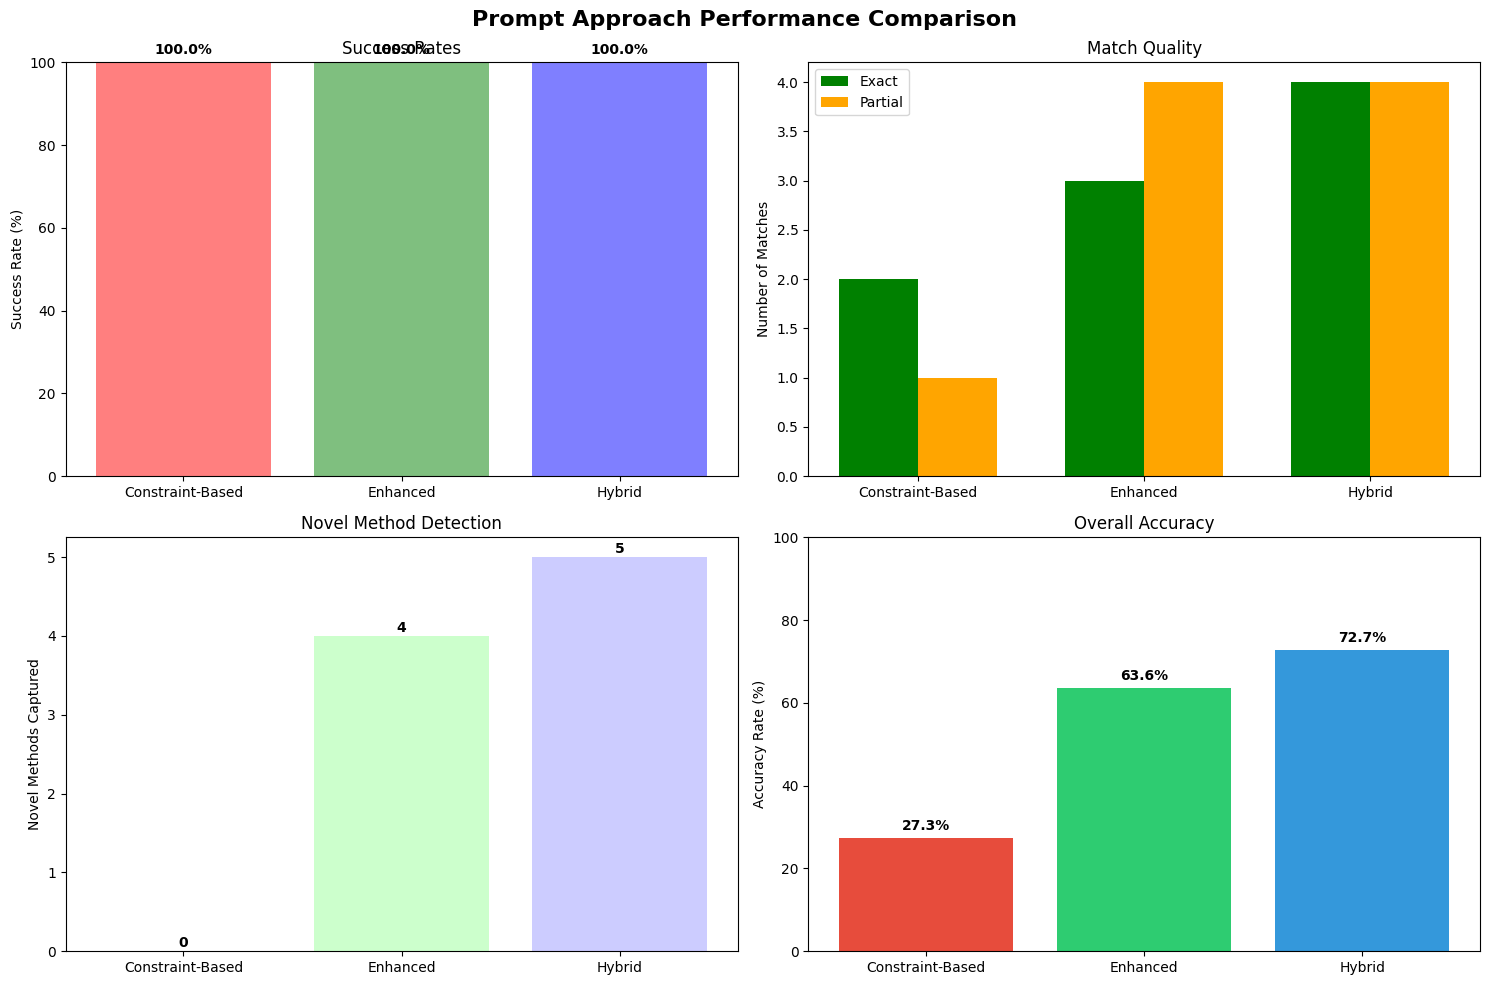

In [15]:
# Visualize prompt comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Prompt Approach Performance Comparison', fontsize=16, fontweight='bold')

approaches = list(prompt_analysis.keys())
success_rates = [prompt_analysis[a]['success_rate'] for a in approaches]
accuracy_rates = [prompt_analysis[a]['accuracy_rate'] for a in approaches]
exact_matches = [prompt_analysis[a]['exact_matches'] for a in approaches]
partial_matches = [prompt_analysis[a]['partial_matches'] for a in approaches]
novel_counts = [novel_detections[a] for a in approaches]

# Success rates
axes[0,0].bar(approaches, success_rates, color=['#ff7f7f', '#7fbf7f', '#7f7fff'])
axes[0,0].set_title('Success Rates')
axes[0,0].set_ylabel('Success Rate (%)')
axes[0,0].set_ylim(0, 100)
for i, v in enumerate(success_rates):
    axes[0,0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

# Match quality
x = range(len(approaches))
width = 0.35
axes[0,1].bar([i - width/2 for i in x], exact_matches, width, label='Exact', color='green')
axes[0,1].bar([i + width/2 for i in x], partial_matches, width, label='Partial', color='orange')
axes[0,1].set_title('Match Quality')
axes[0,1].set_ylabel('Number of Matches')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(approaches)
axes[0,1].legend()

# Novel method detection
axes[1,0].bar(approaches, novel_counts, color=['#ffcc99', '#ccffcc', '#ccccff'])
axes[1,0].set_title('Novel Method Detection')
axes[1,0].set_ylabel('Novel Methods Captured')
for i, v in enumerate(novel_counts):
    axes[1,0].text(i, v + 0.05, str(v), ha='center', fontweight='bold')

# Overall accuracy
axes[1,1].bar(approaches, accuracy_rates, color=['#e74c3c', '#2ecc71', '#3498db'])
axes[1,1].set_title('Overall Accuracy')
axes[1,1].set_ylabel('Accuracy Rate (%)')
axes[1,1].set_ylim(0, 100)
for i, v in enumerate(accuracy_rates):
    axes[1,1].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Results Analysis and Implementation Guide

Comprehensive analysis of prompting approaches with implementation recommendations.

In [16]:
# Create detailed comparison table with emoji accuracy indicators
def get_accuracy_emoji(accuracy_status):
    """Convert accuracy status to emoji"""
    if accuracy_status == 'Exact':
        return '✅ Exact'
    elif accuracy_status == 'Partial':
        return '🟡 Partial'
    elif accuracy_status == 'Failed':
        return '❌ Failed'
    else:
        return '❌ Different'

print("\n" + "="*70)
print("📋 DETAILED COMPARISON TABLE")
print("="*84)
print(f"{'Paper':<25} {'Expected':<20} {'Prompt':<15} {'Extracted':<40} {'Accuracy'}")
print("-"*84)

# Create table showing all combinations of papers and approaches
for paper in TEST_PAPERS:
    paper_title = paper['title'][:24]  # Truncate long titles
    expected_method = paper['expected_method'][:19]  # Truncate long methods
    
    for approach_name in ['Constraint-Based', 'Enhanced', 'Hybrid']:
        # Find the result for this paper and approach
        paper_result = None
        for result in prompt_results[approach_name]:
            if result['paper_title'] == paper['title']:
                paper_result = result
                break
        
        if paper_result:
            prompt_short = approach_name[:14]
            extracted = paper_result['extracted'][:39] if paper_result['success'] else 'FAILED'
            accuracy_emoji = get_accuracy_emoji(paper_result['accuracy'])
            
            print(f"{paper_title:<25} {expected_method:<20} {prompt_short:<15} {extracted:<40} {accuracy_emoji}")

print("\n🎯 Table Legend:")
print("✅ Exact    - Perfect match with expected method")
print("🟡 Partial  - Contains expected method or close match") 
print("❌ Different - No match with expected method")
print("❌ Failed   - Extraction failed or error occurred")

print("=" * 50) #Separator for clarity
print("📊 Summary of Findings")
# Compare performance improvements
constraint_acc = prompt_analysis['Constraint-Based']['accuracy_rate']
enhanced_acc = prompt_analysis['Enhanced']['accuracy_rate']
hybrid_acc = prompt_analysis['Hybrid']['accuracy_rate']

print(f"1. ✅ Enhanced approach vs Constraint-based: {enhanced_acc - constraint_acc:+.1f}% improvement")
print(f"2. ⚡ Hybrid approach vs Constraint-based: {hybrid_acc - constraint_acc:+.1f}% improvement")
print(f"3. 🆕 Novel methods captured by Enhanced: {novel_detections['Enhanced']}/{len(novel_methods)}")
print(f"4. 🆕 Novel methods captured by Hybrid: {novel_detections['Hybrid']}/{len(novel_methods)}")
print(f"5. 🏆 Best overall approach: {best_approach} ({prompt_analysis[best_approach]['accuracy_rate']:.1f}% accuracy)")


📋 DETAILED COMPARISON TABLE
Paper                     Expected             Prompt          Extracted                                Accuracy
------------------------------------------------------------------------------------
Hydrothermal Synthesis o  hydrothermal         Constraint-Bas  hydrothermal                             ✅ Exact
Hydrothermal Synthesis o  hydrothermal         Enhanced        hydrothermal synthesis                   🟡 Partial
Hydrothermal Synthesis o  hydrothermal         Hybrid          hydrothermal                             ✅ Exact
SILAR Deposition of CdS   Sequential Ion-Laye  Constraint-Bas  chemical bath deposition                 ❌ Different
SILAR Deposition of CdS   Sequential Ion-Laye  Enhanced        Sequential Ion-Layer Adsorption and Rea  ✅ Exact
SILAR Deposition of CdS   Sequential Ion-Laye  Hybrid          Sequential Ion-Layer Adsorption and Rea  ✅ Exact
Sol-Gel Synthesis of TiO  sol-gel              Constraint-Bas  sol-gel                         